# <font color=green>Recurrent Neural Networks for D1 Time frame</font>

# <font color=green>Import Libraries</font>

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# <font color=green>D1 Timeframe</font>

In [2]:
# read in D1 timeframe price data
df_d1_feature = pd.read_csv('../data/df_d1_feature.csv', index_col=0)
df_d1_feature.index = pd.to_datetime(df_d1_feature.index)
df_d1_feature = df_d1_feature.dropna()
df_d1_feature.head()

,open,high,low,close,results,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1.0772,1.0822,1.0738,1.0802,1,1,1.0773,2.9,1.0754,4.8,1.0755,4.7,1.0781,2.1,1.0644,15.8,1.0914,-11.2,1.0525,27.7,1.0993,-19.1,1.0729,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,1.077633,2.566667,1.07732,2.88,1.075587,4.6125,1.075538,4.661538,1.074671,5.528571,1.076515,3.685294,1.078116,2.083636,1.074019,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,0.0029,0.0029,0.0000,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,1.0803,1.0979,1.0800,1

In [3]:
df_d1_feature.shape

(5211, 185)

In [4]:
df_d1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5211 entries, 2003-04-15 to 2019-12-23
Columns: 185 entries, open to rsi_14_sma_21m02
dtypes: float64(183), int64(2)
memory usage: 7.4 MB


In [5]:
# define features and multi-class results for modelling
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_d1_feature.columns if col not in non_feature]

X = df_d1_feature[features]
y = df_d1_feature['results']

## <font color=green>Train Test Split</font>

In [6]:
# shuffle=False for unrandomized time-series modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1,2.9,4.8,4.7,2.1,15.8,-11.2,27.7,-19.1,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,2.566667,2.88,4.6125,4.661538,5.528571,3.685294,2.083636,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,2,15.2,18.1,20.0,17.2,30.0,6.9,34.9,-5.5,20.3,1.0384,57.0,-2.9,-1.9,-4.8,2.8,0.9,-2.0,-12.8,-10.0,-11.9,-14.8,23.1,10.3,13.1,11.2,8.3,-28.0,-4.9,-17.7,-14.9,-16.8,-19.7,40.4,12.4,35.5,22.7,25.5,23.6,20.7,-25.8,14.6,-13.4,9.7,-3.1,-0.3,-2.2,-5.1,-36.7,-62.5,-22.1,-50.1,-27.0,-39.8,-37.0,-38.9,-41.8,1.08780,7.60,11.100000,14.64,16.0625,19.330769,19.066667,19.047059,16.914545,20.740449,-

In [8]:
print(X_train.shape)
print(X_test.shape)

(3908, 160)
(1303, 160)


In [9]:
y_train.value_counts(normalize=True)

1    0.475947
2    0.426305
0    0.097748
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

2    0.363776
1    0.339985
0    0.296239
Name: results, dtype: float64

<font color=red>Due to the nature of price volatility changes and non-randomize train-test sets, the baseline accuracies for train and test sets can be rather different</font>

## <font color=green>Standard Scaler</font>

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# <font color=green>Recurrent Neural Networds</font>

In [12]:
# reshape multi-class labels into 3 cols array
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## <font color=green>Training sequence = 1</font>

In [13]:
# Create training sequences
series_length = 1
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [15]:
# 2 layers, L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
123/123 [==============================] - 2s 13ms/step - loss: 2.0019 - categorical_accuracy: 0.4599 - val_loss: 1.7667 - val_categorical_accuracy: 0.3664
Epoch 2/50
123/123 [==============================] - 1s 6ms/step - loss: 1.3362 - categorical_accuracy: 0.4546 - val_loss: 1.4368 - val_categorical_accuracy: 0.3510
Epoch 3/50
123/123 [==============================] - 1s 6ms/step - loss: 1.0939 - categorical_accuracy: 0.4907 - val_loss: 1.3403 - val_categorical_accuracy: 0.3379
Epoch 4/50
123/123 [==============================] - 1s 6ms/step - loss: 0.9932 - categorical_accuracy: 0.5093 - val_loss: 1.2702 - val_categorical_accuracy: 0.3395
Epoch 5/50
123/123 [==============================] - 1s 6ms/step - loss: 0.9550 - categorical_accuracy: 0.4840 - val_loss: 1.2636 - val_categorical_accuracy: 0.3441
Epoch 6/50
123/123 [==============================] - 1s 7ms/step - loss: 0.9271 - categorica

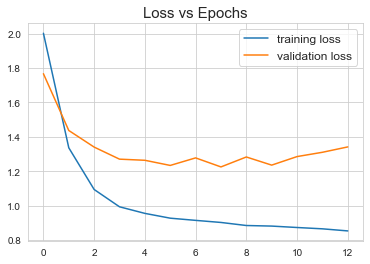

In [18]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

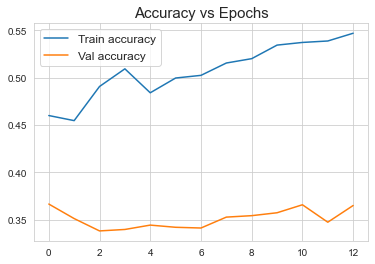

In [19]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [20]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,25,318,43
actual 1,14,355,74
actual 2,17,361,95


In [21]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34332688588007737

In [22]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.4481132075471698

In [23]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3611556982343499

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.035489,0.546767,0.417745
1,0.046123,0.601134,0.352743
2,0.013791,0.448901,0.537308
3,0.013165,0.436734,0.550101
4,0.017889,0.404479,0.577632


In [26]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.035489,0.546767,0.417745
2015-10-22,3,2,1,0,0.046123,0.601134,0.352743
2015-10-23,4,0,2,0,0.013791,0.448901,0.537308
2015-10-25,6,2,2,1,0.013165,0.436734,0.550101
2015-10-26,0,2,2,1,0.017889,0.404479,0.577632


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.035489,0.546767,0.417745
2015-10-22,3,2,1,0,0.046123,0.601134,0.352743
2015-10-27,1,2,1,0,0.059931,0.506548,0.433522
2015-10-28,2,1,1,1,0.073836,0.569722,0.356442
2015-10-29,3,2,1,0,0.036037,0.540376,0.423587


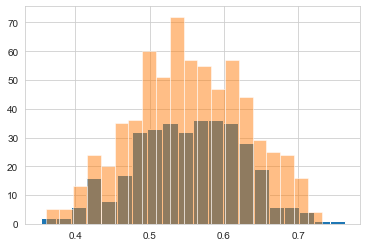

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,2,0,0.013791,0.448901,0.537308
2015-10-25,6,2,2,1,0.013165,0.436734,0.550101
2015-10-26,0,2,2,1,0.017889,0.404479,0.577632
2015-10-30,4,2,2,1,0.012749,0.472768,0.514483
2015-11-01,6,2,2,1,0.019429,0.448396,0.532175


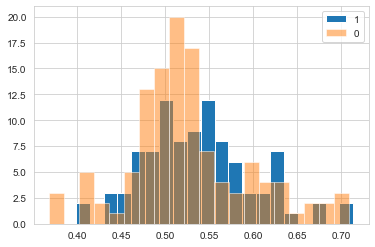

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 2</font>

In [32]:
# Create training sequences
series_length = 2
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [33]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [34]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [35]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [36]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 2s 16ms/step - loss: 2.0873 - categorical_accuracy: 0.4572 - val_loss: 1.9416 - val_categorical_accuracy: 0.3497
Epoch 2/50
123/123 [==============================] - 1s 10ms/step - loss: 1.4685 - categorical_accuracy: 0.4872 - val_loss: 1.5671 - val_categorical_accuracy: 0.3597
Epoch 3/50
123/123 [==============================] - 1s 10ms/step - loss: 1.1972 - categorical_accuracy: 0.4974 - val_loss: 1.4518 - val_categorical_accuracy: 0.3405
Epoch 4/50
123/123 [==============================] - 1s 12ms/step - loss: 1.0659 - categorical_accuracy: 0.4997 - val_loss: 1.3250 - val_categorical_accuracy: 0.3543
Epoch 5/50
123/123 [==============================] - 1s 10ms/step - loss: 0.9995 - categorical_accuracy: 0.5015 - val_loss: 1.3037 - val_categorical_accuracy: 0.3482
Epoch 6/50
123/123 [==============================] - 1s 10ms/step - loss: 0.9564 - categorical_accuracy: 0.5218 - val_loss: 1.2797 - val_categorical_accuracy: 0.353

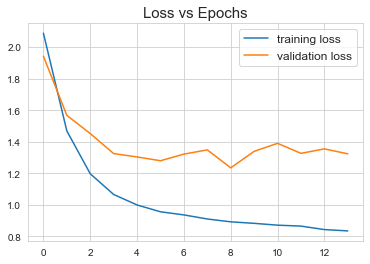

In [37]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

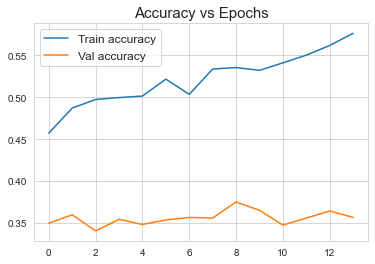

In [38]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [39]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,30,323,33
actual 1,18,355,70
actual 2,24,369,79


In [40]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3390639923591213

In [41]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.4340659340659341

In [42]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3531326281529699

In [43]:
rnn_proba = model.predict_proba(test_sequence)

In [44]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.043838,0.645713,0.310449
1,0.025553,0.599858,0.374589
2,0.021479,0.482001,0.496520
3,0.020358,0.515304,0.464339
4,0.022558,0.580098,0.397344


In [45]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [46]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.043838,0.645713,0.310449
2015-10-23,4,0,1,0,0.025553,0.599858,0.374589
2015-10-25,6,2,2,1,0.021479,0.482001,0.496520
2015-10-26,0,2,1,0,0.020358,0.515304,0.464339
2015-10-27,1,2,1,0,0.022558,0.580098,0.397344


In [47]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.043838,0.645713,0.310449
2015-10-23,4,0,1,0,0.025553,0.599858,0.374589
2015-10-26,0,2,1,0,0.020358,0.515304,0.464339
2015-10-27,1,2,1,0,0.022558,0.580098,0.397344
2015-10-28,2,1,1,1,0.062692,0.629606,0.307702


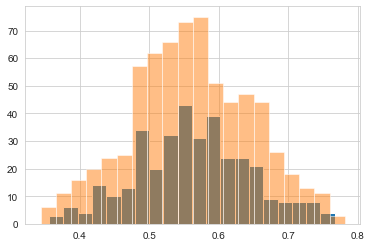

In [48]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [49]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,2,2,1,0.021479,0.482001,0.496520
2015-11-12,3,2,2,1,0.054211,0.469329,0.476459
2015-11-13,4,2,2,1,0.046256,0.402399,0.551345
2015-11-15,6,2,2,1,0.032461,0.438686,0.528853
2015-11-26,3,1,2,0,0.009038,0.486752,0.504210


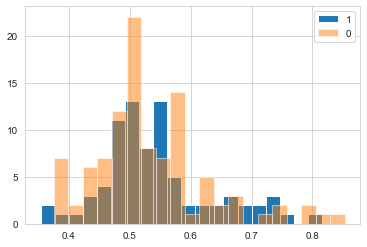

In [50]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 3</font>

In [51]:
# Create training sequences
series_length = 3
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [52]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [53]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [54]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [55]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 3s 23ms/step - loss: 2.1291 - categorical_accuracy: 0.4540 - val_loss: 2.0876 - val_categorical_accuracy: 0.3585
Epoch 2/50
123/123 [==============================] - 2s 13ms/step - loss: 1.5443 - categorical_accuracy: 0.4704 - val_loss: 1.6359 - val_categorical_accuracy: 0.3138
Epoch 3/50
123/123 [==============================] - 2s 14ms/step - loss: 1.2534 - categorical_accuracy: 0.4960 - val_loss: 1.5278 - val_categorical_accuracy: 0.3369
Epoch 4/50
123/123 [==============================] - 2s 20ms/step - loss: 1.1067 - categorical_accuracy: 0.4981 - val_loss: 1.3503 - val_categorical_accuracy: 0.3400
Epoch 5/50
123/123 [==============================] - 3s 27ms/step - loss: 1.0239 - categorical_accuracy: 0.5101 - val_loss: 1.3258 - val_categorical_accuracy: 0.3531
Epoch 6/50
123/123 [==============================] - 3s 27ms/step - loss: 0.9722 - categorical_accuracy: 0.5283 - val_loss: 1.3361 - val_categorical_accuracy: 0.339

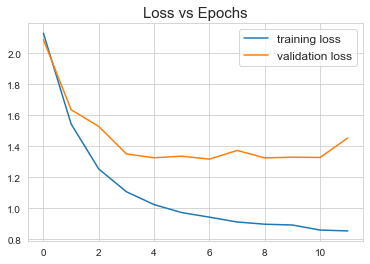

In [56]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

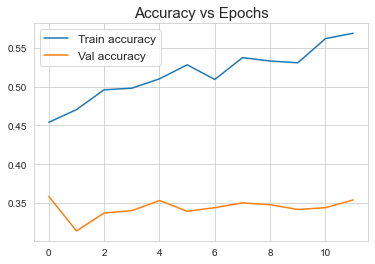

In [57]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [58]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,5,352,29
actual 1,2,389,52
actual 2,3,402,66


In [59]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34033245844269466

In [60]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.4489795918367347

In [61]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35271317829457366

In [62]:
rnn_proba = model.predict_proba(test_sequence)

In [63]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.040303,0.592682,0.367015
1,0.074820,0.519116,0.406064
2,0.065764,0.608124,0.326112
3,0.057924,0.608370,0.333706
4,0.048856,0.590938,0.360206


In [64]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [65]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.040303,0.592682,0.367015
2015-10-25,6,2,1,0,0.074820,0.519116,0.406064
2015-10-26,0,2,1,0,0.065764,0.608124,0.326112
2015-10-27,1,2,1,0,0.057924,0.608370,0.333706
2015-10-28,2,1,1,1,0.048856,0.590938,0.360206


In [66]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.040303,0.592682,0.367015
2015-10-25,6,2,1,0,0.074820,0.519116,0.406064
2015-10-26,0,2,1,0,0.065764,0.608124,0.326112
2015-10-27,1,2,1,0,0.057924,0.608370,0.333706
2015-10-28,2,1,1,1,0.048856,0.590938,0.360206


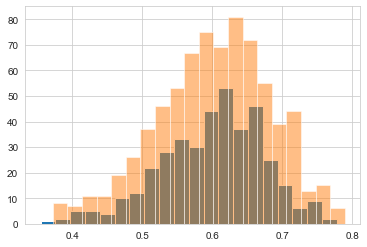

In [67]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [68]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-12-04,4,1,2,0,0.019571,0.439199,0.541230
2016-02-09,1,2,2,1,0.017169,0.394484,0.588347
2016-02-10,2,2,2,1,0.016641,0.345261,0.638099
2016-02-11,3,2,2,1,0.011809,0.410881,0.577310
2016-02-12,4,2,2,1,0.008691,0.481465,0.509844


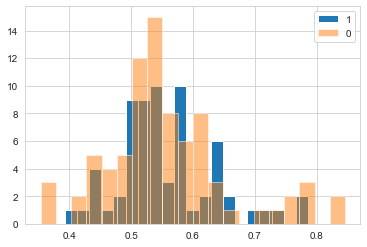

In [69]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 4</font>

In [70]:
# Create training sequences
series_length = 4
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [71]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [72]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [73]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [74]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 6s 53ms/step - loss: 2.1738 - categorical_accuracy: 0.4385 - val_loss: 2.0435 - val_categorical_accuracy: 0.3179
Epoch 2/50
122/122 [==============================] - 4s 35ms/step - loss: 1.5922 - categorical_accuracy: 0.4908 - val_loss: 1.7067 - val_categorical_accuracy: 0.3310
Epoch 3/50
122/122 [==============================] - 4s 35ms/step - loss: 1.3018 - categorical_accuracy: 0.4964 - val_loss: 1.5083 - val_categorical_accuracy: 0.3464
Epoch 4/50
122/122 [==============================] - 4s 36ms/step - loss: 1.1376 - categorical_accuracy: 0.5092 - val_loss: 1.5257 - val_categorical_accuracy: 0.3618
Epoch 5/50
122/122 [==============================] - 5s 37ms/step - loss: 1.0435 - categorical_accuracy: 0.5179 - val_loss: 1.3926 - val_categorical_accuracy: 0.3356
Epoch 6/50
122/122 [==============================] - 4s 33ms/step - loss: 0.9825 - categorical_accuracy: 0.5138 - val_loss: 1.4455 - val_categorical_accuracy: 0.341

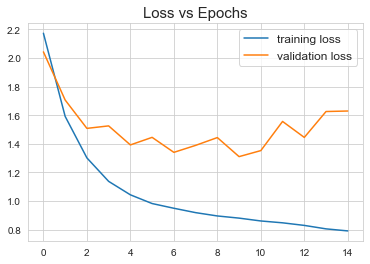

In [75]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

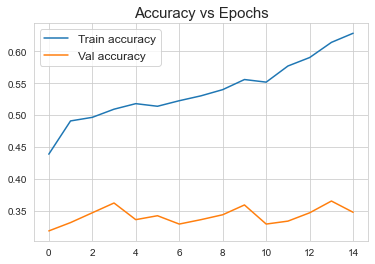

In [76]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [77]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,4,234,147
actual 1,5,275,163
actual 2,4,295,172


In [78]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3420398009950249

In [79]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.35684647302904565

In [80]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3475894245723173

In [81]:
rnn_proba = model.predict_proba(test_sequence)

In [82]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.010219,0.475776,0.514005
1,0.013111,0.329890,0.656999
2,0.079172,0.373788,0.547040
3,0.132380,0.458733,0.408887
4,0.079691,0.512336,0.407973


In [83]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [84]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,2,2,1,0.010219,0.475776,0.514005
2015-10-26,0,2,2,1,0.013111,0.329890,0.656999
2015-10-27,1,2,2,1,0.079172,0.373788,0.547040
2015-10-28,2,1,1,1,0.132380,0.458733,0.408887
2015-10-29,3,2,1,0,0.079691,0.512336,0.407973


In [85]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,1,1,0.132380,0.458733,0.408887
2015-10-29,3,2,1,0,0.079691,0.512336,0.407973
2015-11-02,0,2,1,0,0.016129,0.539896,0.443975
2015-11-03,1,2,1,0,0.016437,0.591367,0.392197
2015-11-04,2,2,1,0,0.016522,0.624149,0.359329


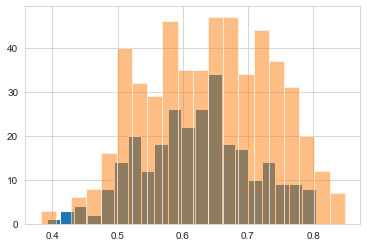

In [86]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [87]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,2,2,1,0.010219,0.475776,0.514005
2015-10-26,0,2,2,1,0.013111,0.329890,0.656999
2015-10-27,1,2,2,1,0.079172,0.373788,0.547040
2015-10-30,4,2,2,1,0.035537,0.445566,0.518897
2015-11-01,6,2,2,1,0.020357,0.409513,0.570130


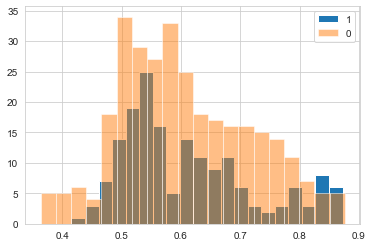

In [88]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 5</font>

In [89]:
# Create training sequences
series_length = 5
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [90]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [91]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [92]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [93]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 6s 53ms/step - loss: 2.2018 - categorical_accuracy: 0.4468 - val_loss: 2.1498 - val_categorical_accuracy: 0.3413
Epoch 2/50
122/122 [==============================] - 5s 40ms/step - loss: 1.6454 - categorical_accuracy: 0.4748 - val_loss: 1.7167 - val_categorical_accuracy: 0.3636
Epoch 3/50
122/122 [==============================] - 5s 40ms/step - loss: 1.3320 - categorical_accuracy: 0.4945 - val_loss: 1.5153 - val_categorical_accuracy: 0.3482
Epoch 4/50
122/122 [==============================] - 5s 40ms/step - loss: 1.1584 - categorical_accuracy: 0.5119 - val_loss: 1.4291 - val_categorical_accuracy: 0.3598
Epoch 5/50
122/122 [==============================] - 5s 41ms/step - loss: 1.0613 - categorical_accuracy: 0.5104 - val_loss: 1.4156 - val_categorical_accuracy: 0.3413
Epoch 6/50
122/122 [==============================] - 5s 38ms/step - loss: 0.9954 - categorical_accuracy: 0.5234 - val_loss: 1.3785 - val_categorical_accuracy: 0.356

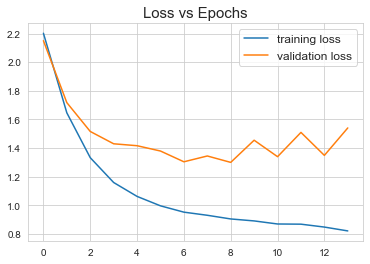

In [94]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

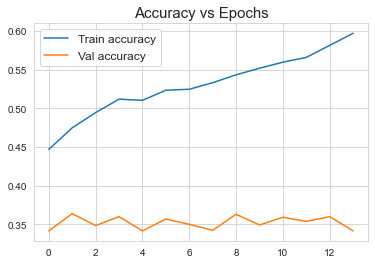

In [95]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [96]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,3,334,48
actual 1,5,357,81
actual 2,4,383,83


In [97]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3324022346368715

In [98]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3915094339622642

In [99]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3421461897356143

In [100]:
rnn_proba = model.predict_proba(test_sequence)

In [101]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.012652,0.583655,0.403693
1,0.025430,0.482814,0.491757
2,0.069752,0.449594,0.480655
3,0.045093,0.530910,0.423997
4,0.016845,0.465333,0.517822


In [102]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [103]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,1,0,0.012652,0.583655,0.403693
2015-10-27,1,2,2,1,0.025430,0.482814,0.491757
2015-10-28,2,1,2,0,0.069752,0.449594,0.480655
2015-10-29,3,2,1,0,0.045093,0.530910,0.423997
2015-10-30,4,2,2,1,0.016845,0.465333,0.517822


In [104]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,1,0,0.012652,0.583655,0.403693
2015-10-29,3,2,1,0,0.045093,0.530910,0.423997
2015-11-04,2,2,1,0,0.019507,0.525621,0.454872
2015-11-05,3,2,1,0,0.018500,0.616526,0.364974
2015-11-06,4,0,1,0,0.020052,0.656775,0.323174


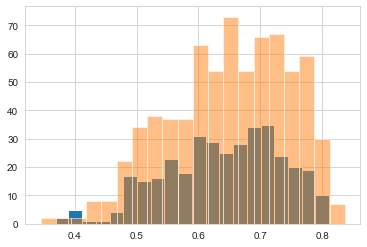

In [105]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [106]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.025430,0.482814,0.491757
2015-10-28,2,1,2,0,0.069752,0.449594,0.480655
2015-10-30,4,2,2,1,0.016845,0.465333,0.517822
2015-11-01,6,2,2,1,0.014060,0.333266,0.652674
2015-11-02,0,2,2,1,0.014204,0.326380,0.659415


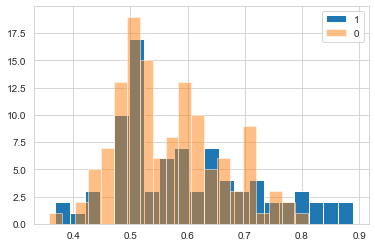

In [107]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 6</font>

In [108]:
# Create training sequences
series_length = 6
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [109]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [110]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [111]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [112]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 7s 61ms/step - loss: 2.1681 - categorical_accuracy: 0.4380 - val_loss: 2.0886 - val_categorical_accuracy: 0.3601
Epoch 2/50
122/122 [==============================] - 5s 44ms/step - loss: 1.5893 - categorical_accuracy: 0.4931 - val_loss: 1.7342 - val_categorical_accuracy: 0.3585
Epoch 3/50
122/122 [==============================] - 5s 44ms/step - loss: 1.3004 - categorical_accuracy: 0.5072 - val_loss: 1.6290 - val_categorical_accuracy: 0.3454
Epoch 4/50
122/122 [==============================] - 5s 41ms/step - loss: 1.1543 - categorical_accuracy: 0.4931 - val_loss: 1.4084 - val_categorical_accuracy: 0.3470
Epoch 5/50
122/122 [==============================] - 5s 44ms/step - loss: 1.0479 - categorical_accuracy: 0.5164 - val_loss: 1.3799 - val_categorical_accuracy: 0.3277
Epoch 6/50
122/122 [==============================] - 5s 44ms/step - loss: 0.9950 - categorical_accuracy: 0.5259 - val_loss: 1.3769 - val_categorical_accuracy: 0.342

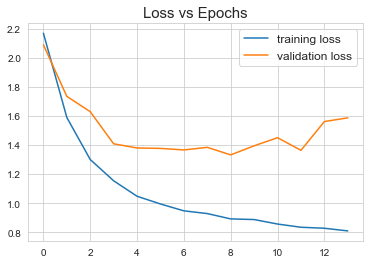

In [113]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

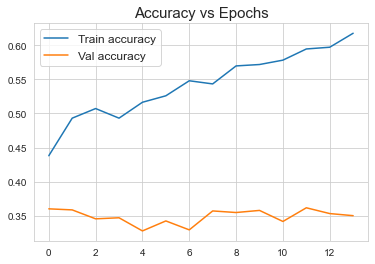

In [114]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [115]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,381,4
actual 1,2,420,21
actual 2,4,431,34


In [116]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3409090909090909

In [117]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.576271186440678

In [118]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3516653756777692

In [119]:
rnn_proba = model.predict_proba(test_sequence)

In [120]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.030854,0.622615,0.346531
1,0.036782,0.687448,0.275771
2,0.032968,0.717569,0.249463
3,0.022713,0.648804,0.328483
4,0.022780,0.506910,0.470310


In [121]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [122]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,1,0,0.030854,0.622615,0.346531
2015-10-28,2,1,1,1,0.036782,0.687448,0.275771
2015-10-29,3,2,1,0,0.032968,0.717569,0.249463
2015-10-30,4,2,1,0,0.022713,0.648804,0.328483
2015-11-01,6,2,1,0,0.022780,0.506910,0.470310


In [123]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,1,0,0.030854,0.622615,0.346531
2015-10-28,2,1,1,1,0.036782,0.687448,0.275771
2015-10-29,3,2,1,0,0.032968,0.717569,0.249463
2015-10-30,4,2,1,0,0.022713,0.648804,0.328483
2015-11-01,6,2,1,0,0.022780,0.506910,0.470310


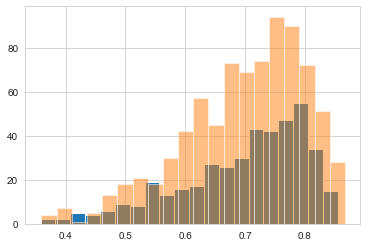

In [124]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [125]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-11-02,0,2,2,1,0.026816,0.470783,0.502401
2015-11-13,4,2,2,1,0.026706,0.473200,0.500094
2016-03-11,4,1,2,0,0.093705,0.355726,0.550569
2016-03-13,6,1,2,0,0.143374,0.411468,0.445159
2016-03-18,4,2,2,1,0.139312,0.401829,0.458859


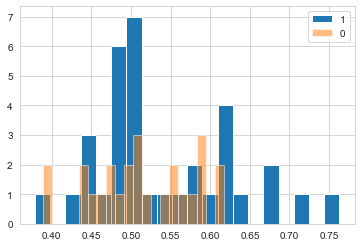

In [126]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 7</font>

In [127]:
# Create training sequences
series_length = 7
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [128]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [129]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [130]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [131]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 7s 60ms/step - loss: 2.2161 - categorical_accuracy: 0.4563 - val_loss: 2.1941 - val_categorical_accuracy: 0.3457
Epoch 2/50
122/122 [==============================] - 4s 34ms/step - loss: 1.6583 - categorical_accuracy: 0.4791 - val_loss: 1.8606 - val_categorical_accuracy: 0.3256
Epoch 3/50
122/122 [==============================] - 4s 31ms/step - loss: 1.3589 - categorical_accuracy: 0.4986 - val_loss: 1.5825 - val_categorical_accuracy: 0.3349
Epoch 4/50
122/122 [==============================] - 3s 25ms/step - loss: 1.1879 - categorical_accuracy: 0.5129 - val_loss: 1.4842 - val_categorical_accuracy: 0.3480
Epoch 5/50
122/122 [==============================] - 3s 25ms/step - loss: 1.0788 - categorical_accuracy: 0.5194 - val_loss: 1.4164 - val_categorical_accuracy: 0.3449
Epoch 6/50
122/122 [==============================] - 3s 28ms/step - loss: 1.0102 - categorical_accuracy: 0.5178 - val_loss: 1.3995 - val_categorical_accuracy: 0.339

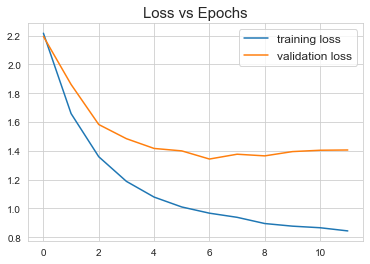

In [132]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

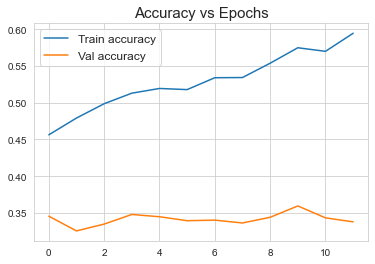

In [133]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [134]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,9,350,26
actual 1,18,371,54
actual 2,13,397,58


In [135]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.33184257602862255

In [136]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.42028985507246375

In [137]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.34156050955414013

In [138]:
rnn_proba = model.predict_proba(test_sequence)

In [139]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.071909,0.509662,0.418429
1,0.071553,0.500525,0.427922
2,0.069379,0.440437,0.490184
3,0.059507,0.371510,0.568983
4,0.052889,0.387029,0.560082


In [140]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [141]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,1,1,0.071909,0.509662,0.418429
2015-10-29,3,2,1,0,0.071553,0.500525,0.427922
2015-10-30,4,2,2,1,0.069379,0.440437,0.490184
2015-11-01,6,2,2,1,0.059507,0.371510,0.568983
2015-11-02,0,2,2,1,0.052889,0.387029,0.560082


In [142]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,1,1,0.071909,0.509662,0.418429
2015-10-29,3,2,1,0,0.071553,0.500525,0.427922
2015-11-03,1,2,1,0,0.057630,0.481880,0.460490
2015-11-04,2,2,1,0,0.043705,0.588753,0.367542
2015-11-05,3,2,1,0,0.031710,0.652002,0.316288


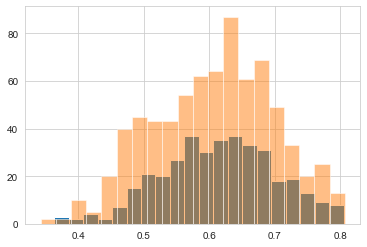

In [143]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [144]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-30,4,2,2,1,0.069379,0.440437,0.490184
2015-11-01,6,2,2,1,0.059507,0.371510,0.568983
2015-11-02,0,2,2,1,0.052889,0.387029,0.560082
2015-11-10,1,2,2,1,0.059347,0.467900,0.472753
2015-11-11,2,2,2,1,0.069960,0.284949,0.645091


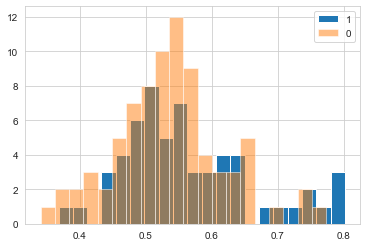

In [145]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()